In [1]:
# IMPORTING THE NECESS ARY LIBRARY
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers  import adam

Using TensorFlow backend.


In [2]:
# FUNCTION FOR LOADING THE DATA
def load_data():
    (x_train, y_train), (x_test, y_test)= mnist.load_data()
    # convert the shape from (60,000,28,28) to (60,000,784)
    x_train= x_train.reshape(60000,784)
    return(x_train, y_train, x_test, y_test)
(X_train, Y_train, X_test, Y_test)= load_data()
print(X_train.shape)

(60000, 784)


In [3]:
# FUNCTION FOR THE OPTIMIZATION FUNCTION
def adam_optim():
    return(adam(lr= 0.002))

In [4]:
# FUNCTION FOR CREATING GENERATOR MODEL
def create_generator():
    generator= Sequential()
    generator.add(Dense(256, input_dim= 100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units= 512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(784, activation= "tanh"))
    generator.compile(loss="binary_crossentropy", optimizer= adam_optim())
    
    return(generator)

g= create_generator()
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)              

In [5]:
# FUNCTION FOR THE DESCRIMINATOR MODEL
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optim())
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

* We can now create GAN where we combine the Gnerator and Discriminator.
  While training the Generator we freeze the Discriminator
* We will input noised image of shape 100 units to the generator. The output generator will be fed to the Discriminator

In [6]:
# MAIN FUNCTION FOR CRETING GAN MODEL
def create_gan(discriminator, generator):
    discriminator.trainable= False
    gan_input= Input(shape= (100,))
    x= generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs= gan_input, output= gan_output)
    gan.compile(loss= "binary_crossentropy", optimizer= "adam")
    return(gan)

gan= create_gan(d,g)
gan.summary()

C:\Users\Lenovo\ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [7]:
# FUNCTION FOR PLOTTING IMAGES
def plot_generated_images( epoch, generator, example= 100, dim=(10,10), figsize= (10,10)):
    noise= np.random.normal(loc= 0, scale= 1, size= [example, 100])
    generated_images= generator.predict(noise)
    generated_images= generated_images.reshape(100, 28, 28)
    plt.figure(figsize= figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation= "nearest")
        plt.axis("off")
    plt.tight_layout()

In [8]:
# FUNCTION FOR TAINING THE GAN MODEL
def training(epochs= 1, batch_size= 128):
    # Loading the data
    (X_train, Y_train, X_test, Y_test)= load_data()
    batch_count= X_train.shape[0] / batch_size
     
    # CREATING GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan= create_gan(generator, discriminator)
    for e in range(1, epochs +1):
        print("EPOCH %d " %e)
        for _ in tqdm(range(batch_count)):
            # Generate random noise as input for generator
            noise= np.random.normal(0,1,[batch_size, 100])
            # Generate fake MNIST images from noised input
            generated_images= generator.predict(noise)
            # Get a random set of the real images
            image_batch= X_train[np.random.randint(low= 0, high= X_train.shape[0], size= batch_size)]
            x= np.concatenate([image_batch,generated_images])
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            descriminator.trainable= True
            discriminator.train_on_batch(X,y_dis)
        
            # Tricking the weights generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
        
            # During the training of gan,
            # the weights of the discriminator should be fixed.
            descriminator.trainable= False
            gan.train_on_batch(noise, y_gen)
        if(e==1 or e%20==0):
            plot_generated_image(e, generator)
training(400,128)

ValueError: Dimensions must be equal, but are 100 and 784 for 'sequential_4/dense_13/MatMul' (op: 'MatMul') with input shapes: [?,100], [784,1024].

In [ ]:
# REWRITING THE ABPVE CODE ONCE AGAIN FOR ERROR REMOVING 

In [9]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
   # generator.compile(loss='binary_crossentropy', optimizer=adam_optim())
    return generator
g=create_generator()
g.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 784)              

In [10]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optim())
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)              

In [11]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

C:\Users\Lenovo\ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


Epoch 1


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.10it/s]


Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.74it/s]


Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.67it/s]


Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.11it/s]


Epoch 5


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.91it/s]


Epoch 6


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.25it/s]


Epoch 7


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.13it/s]


Epoch 8


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.08it/s]


Epoch 9


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.21it/s]


Epoch 10


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.25it/s]


Epoch 11


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.87it/s]


Epoch 12


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.64it/s]


Epoch 13


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:16<00:00,  7.74it/s]


Epoch 14


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.23it/s]


Epoch 15


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.25it/s]


Epoch 16


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:17<00:00,  7.26it/s]


Epoch 17


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [22:15<00:00, 10.44s/it]


Epoch 18


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:13<00:00,  9.73it/s]


Epoch 19


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.52it/s]


Epoch 20


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:14<00:00,  9.14it/s]


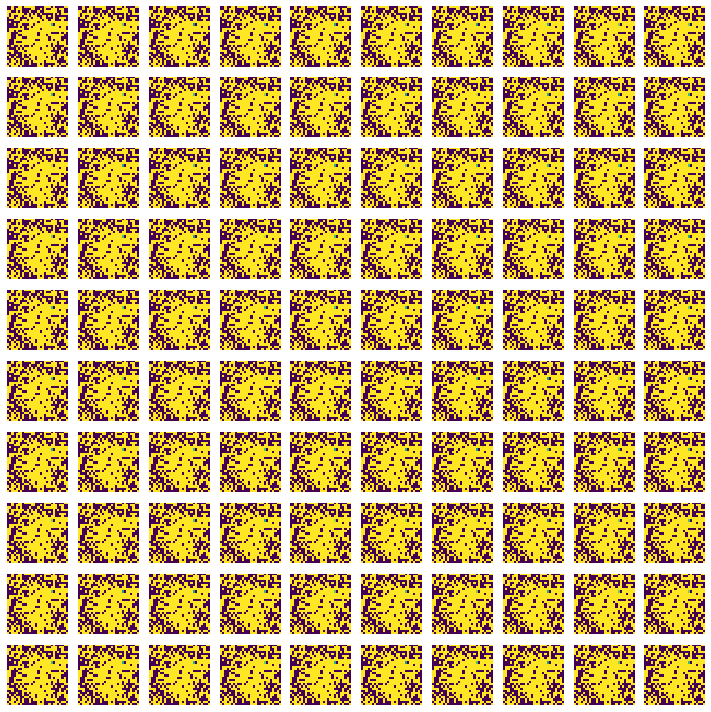

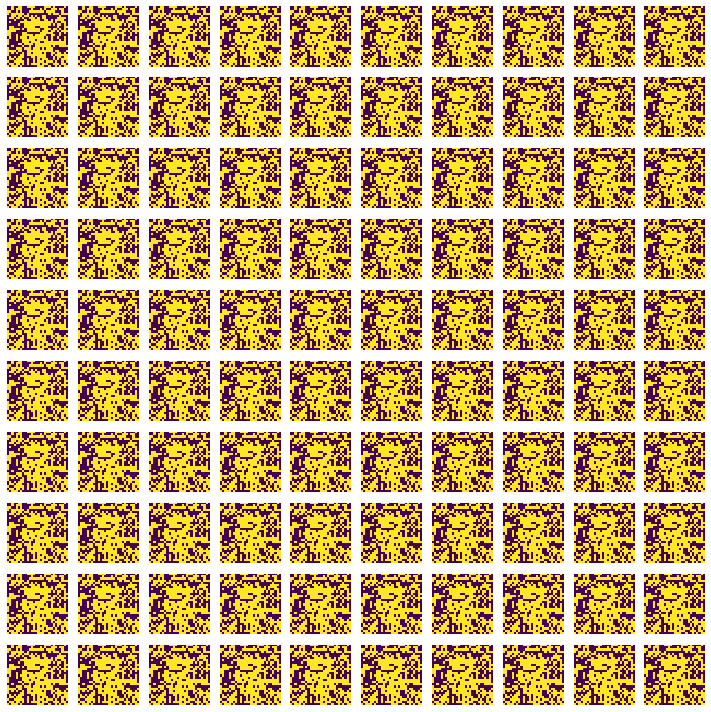

In [12]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
training(20,128)